1. Import & Path

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

INT  = Path("data/interim")
PROC = Path("data/processed"); PROC.mkdir(parents=True, exist_ok=True)
FIG  = Path("reports/figures"); FIG.mkdir(parents=True, exist_ok=True)
TBL  = Path("reports/tables"); TBL.mkdir(parents=True, exist_ok=True)

2. Load Merged & QC

In [2]:
merged_path = INT/"merged_gold_btc_monthly_2020_2025.csv"
assert merged_path.exists(), f"File is not exist: {merged_path}. Run step 04 first."

df = pd.read_csv(merged_path, parse_dates=["Date"]).set_index("Date").sort_index()
# Make sure index = end-month
df.index = df.index.to_period("M").to_timestamp("M")
df = df[~df.index.duplicated(keep="last")].dropna()

print("Shape:", df.shape)
print("Range:", df.index.min(), "->", df.index.max())

Shape: (67, 2)
Range: 2020-01-31 00:00:00 -> 2025-07-31 00:00:00


3. Level Summary and Line Drawing

Saved table -> C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\tables\level_summary.csv


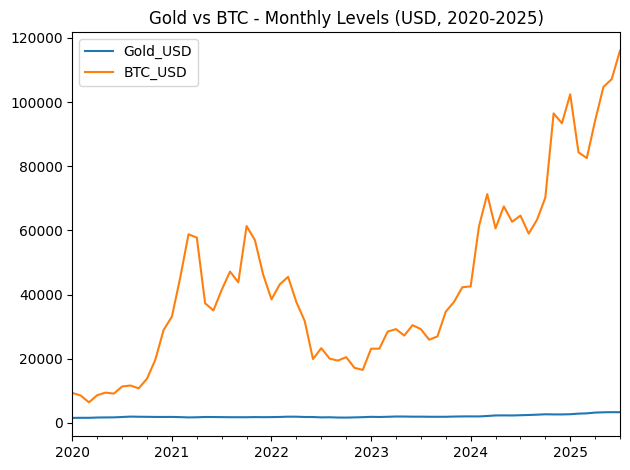

Saved figure -> C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\figures\level_gold_btc.png


In [3]:
level_summary = df.describe().round(3)
level_summary.to_csv(TBL/"level_summary.csv")
print("Saved table ->", (TBL/"level_summary.csv").resolve())

ax = df.plot(title="Gold vs BTC - Monthly Levels (USD, 2020-2025)")
ax.set_xlabel("")
plt.tight_layout()
plt.savefig(FIG/"level_gold_btc.png", dpi=140)
plt.show()
print("Saved figure ->", (FIG/"level_gold_btc.png").resolve())

4. Calculate Monthly Log Returns & Save

In [4]:
ret = df.assign(
    Gold_ret = np.log(df["Gold_USD"]).diff(),
    BTC_ret  = np.log(df["BTC_USD"]).diff()
).dropna(subset=["Gold_ret","BTC_ret"])

ret.to_csv(PROC/"monthly_returns_gold_btc_2020_2025.csv", index_label="Date")
print("Saved returns ->", (PROC/"monthly_returns_gold_btc_2020_2025.csv").resolve())

ret_summary = ret[["Gold_ret","BTC_ret"]].describe().round(4)
ret_summary.to_csv(TBL/"returns_summary.csv")
print("Saved table ->", (TBL/"return_summary.csv").resolve())
display(ret_summary)

Saved returns -> C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\data\processed\monthly_returns_gold_btc_2020_2025.csv
Saved table -> C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\tables\return_summary.csv


,Gold_ret,BTC_ret
count,66.0000,66.0000
mean,0.0115,0.0382
std,0.0315,0.1828
min,-0.0582,-0.4678
25%,-0.0095,-0.0736
50%,0.0065,0.0346
75%,0.0308,0.1339
max,0.0773,0.3864


5. Returns (Line) and Scatter Graphs

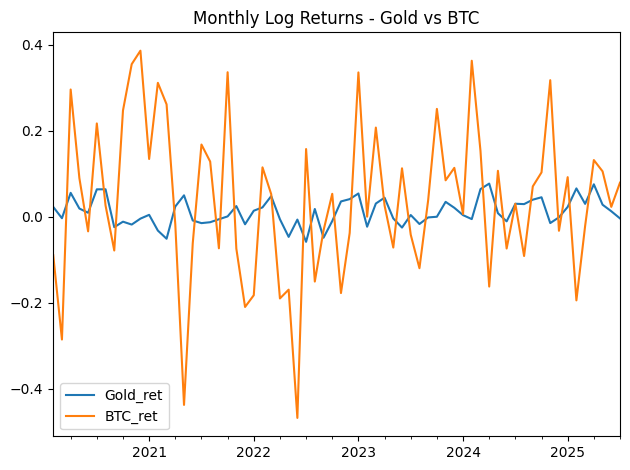

Saved figure -> C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\figures\returns_gold_btc.png


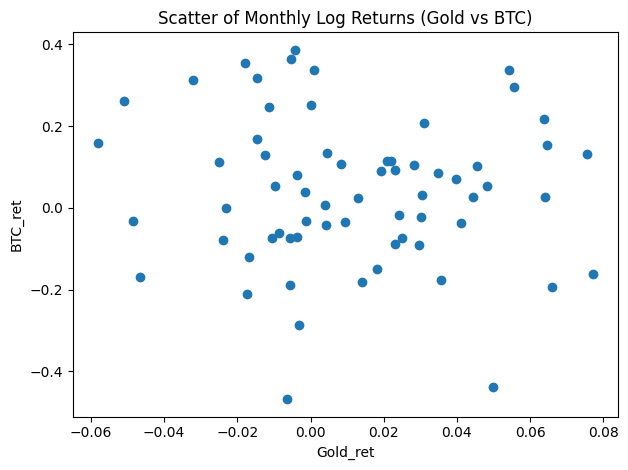

Saved figure → C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\figures\scatter_returns_gold_btc.png


In [5]:
# Returns graphs
ax = ret[["Gold_ret","BTC_ret"]].plot(title="Monthly Log Returns - Gold vs BTC")
ax.set_xlabel("")
plt.tight_layout()
plt.savefig(FIG/"returns_gold_btc.png", dpi=140)
plt.show()
print("Saved figure ->", (FIG/"returns_gold_btc.png").resolve())

# Scatter returns
plt.figure()
plt.scatter(ret["Gold_ret"], ret["BTC_ret"])
plt.title("Scatter of Monthly Log Returns (Gold vs BTC)")
plt.xlabel("Gold_ret")
plt.ylabel("BTC_ret")
plt.tight_layout()
plt.savefig(FIG/"scatter_returns_gold_btc.png", dpi=140)
plt.show()
print("Saved figure →", (FIG/"scatter_returns_gold_btc.png").resolve())

6. Additional Quality Control (QC)

In [6]:
na_counts = df.isna().sum()
same_index = (df.index.to_series().diff().dt.days.dropna() == 0).sum()
print("NA per column:\n", na_counts)
print("Duplicate adjacent index count:", same_index)

NA per column:
 Gold_USD    0
BTC_USD     0
dtype: int64
Duplicate adjacent index count: 0
